# 0 思路

*交易相关*
1. 每个特征的的交易量, 交易率
2. item_brand_id分类及销量排名
3. 交易频次
4. 交易时段 (类目定义)

*交易率平滑修正*
1. 弄清楚平滑的正负向对于各个id的交易率是否不一致
2. 弄清楚平滑的正负向是否kfold表现一致
3. 弄清楚每个id的正向平滑

In [225]:
import sys
sys.path.append("..")
import pandas as pd

train_df = pd.read_table('../../round1_ijcai_18_train_20180301.txt',sep=' ')
test_df = pd.read_table('../../round1_ijcai_18_test_a_20180301.txt',sep=' ')

# 线下线上数据统一进行特征处理
test_df['is_trade'] = -1
total_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

# 1 先处理时序数据

In [226]:
# 时间处理: 分离天, 星期几, 上中下午/晚上, 小时数
# date最终不使用，直接用day(第 0 - 7 天)

from sklearn import preprocessing
from datetime import datetime
le = preprocessing.LabelEncoder()

def extract_date(x):
    d = datetime.fromtimestamp(x)
    return d.strftime('%Y-%m-%d')
def extract_weekday(x):
    d = datetime.fromtimestamp(x)
    return d.weekday()
def extract_hour(x):
    d = datetime.fromtimestamp(x)
    return d.hour

total_df['date'] = total_df['context_timestamp'].apply(lambda x: extract_date(x))
total_df['day'] = le.fit_transform(total_df['date'])
total_df['weekday'] = total_df['context_timestamp'].apply(lambda x: extract_weekday(x))
total_df['hour'] = total_df['context_timestamp'].apply(lambda x: extract_hour(x))

In [227]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 2 先分离训练集, 测试集, 线上集



In [353]:
# 保存原始数据
import numpy as np
tmp_df = total_df.copy()

In [354]:
# 获取训练测试的索引, 6全集数据验证, 7为生成上线文件
test_day= 6
starts = list(range(0,test_day))
ends = [test_day]
train_indices = tmp_df[tmp_df['day'].isin(starts)].index.values
test_indices = tmp_df[tmp_df['day'].isin(ends)].index.values
print(train_indices.shape, test_indices.shape)

# 把测试索引的label提取
y_test = tmp_df.iloc[test_indices]['is_trade']

# 把需要训练和测试的数据提取, 并且强制去掉测试集的label列
tmp_df.loc[test_indices, 'is_trade'] = np.nan

# 得出训练测试必须的数据集 ,并且添加一列data_set作为标记
train_tmp = tmp_df.iloc[train_indices].copy()
train_tmp['data_set'] = 'training'
test_tmp = tmp_df.iloc[test_indices].copy()
test_tmp['data_set'] = 'testing'
raw_df = train_tmp.append(test_tmp)


(420717,) (57421,)


In [355]:
%run ../util/time_utils.py
dup_feat = ['item_id', 'item_brand_id', 'shop_id', 'user_id']
raw_df = generateColDupByDay(raw_df, dup_feat, list(range(1, 8)), verbose=False)

### 平滑效果分析

*比较方法: 单特征, 多特征比较*

1. 单一特征不平滑可能更好, 但是多特征平滑更好
2. 外部平滑与内部平滑效果一致
3. 每个特征都有最佳的平滑参数?
4. 平滑参数与特征的什么有关系?



#### item_city_id单特征实验记录 

> 所有day使用相同平滑

> no -> 0.08276

> 内部平滑 -> 0.08280

> 10*mean0, 10 -> 0.08279  

> 20*mean0, 20 -> 0.08277

> 30*mean0, 30 -> 0.08278

#### 多特征平滑优化

> (10\*mean0,10,loss:0.08209) -> (15\*mean0, 15,loss:0.08204)


#### 总体效果, 是否平滑, 使用外部还是内部平滑

> 使用外部平滑, 总体效果0.08201

> 使用内部平滑, 总体效果

In [356]:
# %run ../util/bayesian_smoothing.py
# %run ../util/trade_info.py


total_days = 8
tmp = raw_df.copy()
d1 = np.logical_and(tmp.day.values <= max(test_day - 1, 0), tmp.day.values > (test_day - 7))
mean0 = raw_df.loc[d1, 'is_trade'].mean()
# d2 = (tmp.day.values == full_day)
# r = calcTVTransform(tmp, 'item_city_id', 'is_trade', d1, d2, smoothing=10)
# # print("column %s trade_rate cal_day %s set to day %s" % (k, tmp[d1]["day"].unique(), full_day))
# smoothing = bs.BayesianSmoothing(1, 1)
# # smoothing.update_from_data_by_moment(r['cnt']+0.000001, r['sum'])
# smoothing.update_from_data_by_FPI(r['cnt']+0.000001, r['sum'], 200, 0.00001)
# print(smoothing.alpha, smoothing.beta)
print(15*mean0, ',', 15)
# # 100, 0,00001 -> 0.401764367583 4.624509808
# # 

0.2870100328724534 , 15


### 交易率特征选择

*固定smooth为10*

1. 特征是否独立提升?
2. 平滑是否不会改变正负向?

##### 正向特征

> item_city_id, shop_id, user_gender_id, item_sales_level, item_collected_level, shop_review_num_level

##### 负向特征

> item_price_level,
item_id,item_brand_id,item_pv_level,user_age_level,
user_occupation_id,user_star_level,context_page_id,
shop_review_positive_rate,shop_star_level,
shop_score_service,shop_score_description,day,hour


In [357]:
# 计算前一天的交易率set到下一天，第0天用回自己
%run ../util/trade_info.py

trade_rela = ['item_city_id', 'shop_id', 'user_gender_id', 'item_sales_level', 'item_collected_level', 'shop_review_num_level']
# trade_rela = ['item_city_id', 'item_id', 'item_brand_id', 'shop_id', 'user_id']

colSm = {}
for col in trade_rela:
    colSm[col] = [15*(mean0) , 15]
generateTradeRateByDate(raw_df, trade_rela, 7, None, verbose=False)
print(raw_df.shape)
# setTradeRateByDate(raw_df, ['item_city_id'], None)

(478138, 73)


# 3 生成矩阵数据

In [358]:
train_df = raw_df[raw_df['data_set'] == 'training']
test_df = raw_df[raw_df['data_set'] == 'testing']

non_feat_columns = ['data_set', 'context_timestamp', 'instance_id', 'is_trade', 'context_id',
                   'item_property_list', 'item_category_list', 'date', 'predict_category_property'
                   ]

D = train_df[['date']]
X_train = train_df.drop(non_feat_columns, axis=1)
y_train = train_df[['is_trade']].values.ravel()
X_test = test_df.drop(non_feat_columns, axis=1)
# y_test never shown in training data, and is already exists

# X_online = test_df.drop(non_feat_columns, axis=1).values
print(D.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(420717, 1) (420717, 64) (420717,) (57421, 64) (57421,)


In [359]:
# 训练模型
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
import xgboost
import lightgbm as lgb

%run ../util/time_series_split.py

# clf = lgb.LGBMClassifier(n_jobs=7)
# clf = xgboost.XGBClassifier(n_jobs=7)
clf = xgboost.XGBClassifier(n_jobs=7, max_depth=3, n_estimators=230)
# clf = xgboost.XGBClassifier(n_jobs=7,max_depth=5,n_estimators=100,min_child_weight=5, scale_pos_weight=1)

m = None

# 如果移动到线上集, 则输出模型
if sum(y_test == -1) > 0:
    m = clf.fit(X_train, y_train)
    result = pd.DataFrame()
    result['instance_id'] = test_df['instance_id']
    result['predicted_score'] = pd.DataFrame(m.predict_proba(X_test))[1].values
    result.to_csv('8182_a8299_b8132.csv', sep = ' ', header=True, index = False)
else:
    # 分离a,b榜
    X_val_a, X_val_b, y_val_a, y_val_b = train_test_split(X_test, y_test, test_size=0.7, shuffle=True, random_state=6)
    m = clf.fit(X_train, y_train)
    
    val_a_loss = log_loss(y_val_a, m.predict_proba(X_val_a))
    val_b_loss = log_loss(y_val_b, m.predict_proba(X_val_b))
    print(clf)
    print('(%s -> %s) train logloss: %.5f, test logloss: %.5f, a: %.5f, b: %.5f' % \
          (starts, ends, \
           log_loss(y_train, m.predict_proba(X_train)), \
           log_loss(y_test, m.predict_proba(X_test)),\
          val_a_loss, val_b_loss))
    
# 4day: 0.08918  0.08905  0.08912
# 6day: 0.08218 -> 0.08214 -> 0.08210 -> 0.08209 -> 0.08204 -> 0.08201
# 调参后: 8199 -> 8218  

# 未调参: 0.08210 -> 0.08205


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=230,
       n_jobs=7, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
([0, 1, 2, 3, 4, 5] -> [6]) train logloss: 0.08677, test logloss: 0.08182, a: 0.08299, b: 0.08132


# 4 调参

In [360]:
from sklearn.model_selection import ParameterGrid

params={
    'max_depth': [3],#[3,4,5,6,7,8,9,10], # 5 is good but takes too long in kaggle env
    'subsample': [1],#[0.1,0.2,0.3,0.4,0.5,0.55,0.6,0.65,0.7,0.8,0.9],#[0.9]
    'colsample_bytree': [1],#[0.1,0.2,0.3,0.4,0.5,0.6,0.65,0.7,0.75,0.8,0.9,0.95],#[0.9],
    'colsample_bylevel':[1],#[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
    'scale_pos_weight':[1],#[0.7,0.8,1,1.1,1.2],#0.1,0.5,1,2,5
    'max_delta_step':[0],#[0,0.1,0.001,0.05,0.005,0.5,1,2],
    'n_estimators': [230],#[350,370,390,400,410,420],#400,[100,400,500,700,1000,1500,2000],
    'reg_lambda': [1],#[0.05,0.1,0.2,0.3,0.4,0.5,0.7,0.8,0.9]
    'reg_alpha': [0],#[0.01,0.05,0.005,0.2,0.1,0.02,0.0001],#
    'min_child_weight':[1],#[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],#[23],#[20,21,22,23,24,25,26],#
    'gamma':[0],#[1.8,1.9,1.95,2,2.05,2.1,2.2,2.3],#[2],#[0.1,0.5,0.01,1,2,3,4,5,6,7,8],#[6],#[0.1],#
    'learning_rate':[0.05,0.02],#[0.01,0.015,0.02,0.025,0.05,0.005,0.1],#[0.02]#
}

# if sum(y_test == -1) == 0:
#     xgb = xgboost.XGBClassifier(n_jobs=7)
#     best_score = 1 
#     for g in ParameterGrid(params):
#         xgb.set_params(**g)

#         # 分离a,b榜
#         X_val_a, X_val_b, y_val_a, y_val_b = train_test_split(X_test, y_test, test_size=0.7, shuffle=True, random_state=6)
#         m = xgb.fit(X_train, y_train)

#         val_train_loss = log_loss(y_train, m.predict_proba(X_train))
#         val_test_loss = log_loss(y_test, m.predict_proba(X_test))
#         val_a_loss = log_loss(y_val_a, m.predict_proba(X_val_a))
#         val_b_loss = log_loss(y_val_b, m.predict_proba(X_val_b))
#         print('-'*80)
#         print(g)
#         print('(%s -> %s) train logloss: %.5f, test logloss: %.5f, a: %.5f, b: %.5f' % \
#               (starts, ends, val_train_loss, val_test_loss, val_a_loss, val_b_loss))

#         # save if best
#         if val_test_loss < best_score:
#             best_score = val_test_loss
#             best_grid = g

#     print('-'*80, '\n')        
#     print ("log loss: %0.5f" % best_score )
#     print ("Grid:", best_grid)
# 8180

# 5 模型分析

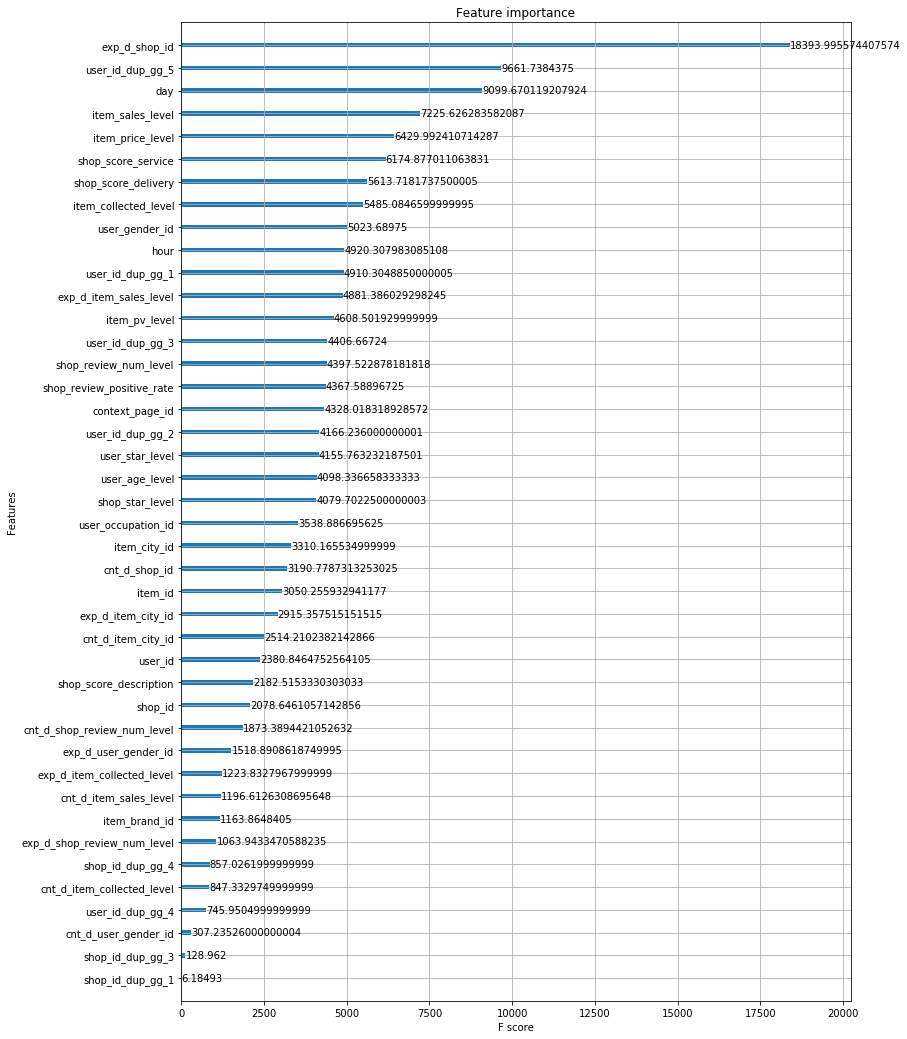

In [361]:
fig,ax = plt.subplots(figsize=(12,18))
xgboost.plot_importance(clf, ax=ax, importance_type='cover')
plt.show()